# Plot qPCR to analyze export from K562 and Jurkat cells

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_K562_Jurkat"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_K562_Jurkat_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

cq_raw = cq_raw.set_index("Sample")
samples_to_keep = ["41-" + str(x) for x in range(1,13)] + ["NTC"]
cq_raw = cq_raw.drop(list(set(cq_raw.index) - set(samples_to_keep)))

print(cq_raw.shape)
cq_raw.head()

(37, 12)


,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Sample,,,,,,,,,,,,
41-1,D01,SYBR,mCherry,Unkn-13,NaN,24.211914,24.302075,0.346141,549.122624,2.739669,523.418717,138.268056
41-2,D02,SYBR,mCherry,Unkn-14,NaN,24.297426,24.592250,0.336659,512.273209,2.709502,413.004239,107.231477
41-3,D03,SYBR,mCherry,Unkn-15,NaN,22.397495,22.280381,0.112231,2397.602508,3.379777,2644.180981,239.285952
41-4,D04,SYBR,mCherry,Unkn-16,NaN,24.648649,24.412790,0.212585,385.118120,2.585594,470.992676,78.324721
41-5,D05,SYBR,mCherry,Unkn-17,NaN,31.018983,30.767503,0.355647,2.178750,0.338207,2.728516,0.777487


# Preprocess data

## Calculate total starting molecules

In [5]:
# Calculate normalization for input volume
DILUTION_FACTORS = (200/140) * (42/20) * (61/10) * (20/1)

In [6]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [7]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Censor by lower limit of quantification

In [8]:
cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]

In [9]:
# Lower limit of quantification is set based on maximum signal from negative control (NTC) wells.

LOD = cq_raw.loc["NTC", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 834852.1227994205


In [10]:
# Censor by setting samples with values less than LOD to LOD
samples_subset = ["41-1", "41-2", "41-3", "41-4", "41-5", "41-6"]
selector = (cq_raw["RNA molecules"] < LOD) & (cq_raw.index.isin(samples_subset))
cq_raw.loc[selector, "RNA molecules censored"] = LOD

In [11]:
# Censor by setting samples with values less than LOD to LOD
samples_subset = ["41-7", "41-8", "41-9", "41-10", "41-11", "41-12"]
selector = (cq_raw["RNA molecules"] < LOD) & (cq_raw.index.isin(samples_subset))
cq_raw.loc[selector, "RNA molecules censored"] = LOD

## Summarize replicates

In [12]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary["RNA molecules censored"] = groups["RNA molecules censored"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored
Sample,,,,,
41-1,523.418717,138.268056,3.215458e+07,8.494064e+06,3.215458e+07
41-10,20.863446,15.365375,1.281680e+06,9.439236e+05,1.391994e+06
41-11,2.403720,0.503951,1.476650e+05,3.095867e+04,8.348521e+05
41-12,13.025423,5.909396,8.001759e+05,3.630252e+05,9.506866e+05
41-2,413.004239,107.231477,2.537162e+07,6.587429e+06,2.537162e+07
41-3,2644.180981,239.285952,1.624370e+08,1.469978e+07,1.624370e+08
41-4,470.992676,78.324721,2.893396e+07,4.811633e+06,2.893396e+07
41-5,2.728516,0.777487,1.676178e+05,4.776249e+04,8.348521e+05
41-6,26.625962,2.787486,1.635682e+06,1.712404e+05,1.635682e+06


# Visualize RNA export by K562

In [13]:
# Choose samples
index_ordered = ["41-1", "41-2", "41-3", "41-5"]

In [14]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(4, 5)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored
Sample,,,,,
41-1,523.418717,138.268056,3.215458e+07,8.494064e+06,3.215458e+07
41-2,413.004239,107.231477,2.537162e+07,6.587429e+06,2.537162e+07
41-3,2644.180981,239.285952,1.624370e+08,1.469978e+07,1.624370e+08
41-5,2.728516,0.777487,1.676178e+05,4.776249e+04,8.348521e+05


In [15]:
# Get data of replicates of selected wells

selector = cq_raw.index.isin(summary_subset.index)
data = cq_raw.loc[selector]

data = data.reset_index()

print(data.shape)
data.head()

(11, 17)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
0,41-1,D01,SYBR,mCherry,Unkn-13,NaN,24.211914,24.302075,0.346141,549.122624,2.739669,523.418717,138.268056,3.373362e+07,3.215458e+07,8.494064e+06,3.373362e+07
1,41-2,D02,SYBR,mCherry,Unkn-14,NaN,24.297426,24.592250,0.336659,512.273209,2.709502,413.004239,107.231477,3.146990e+07,2.537162e+07,6.587429e+06,3.146990e+07
2,41-3,D03,SYBR,mCherry,Unkn-15,NaN,22.397495,22.280381,0.112231,2397.602508,3.379777,2644.180981,239.285952,1.472892e+08,1.624370e+08,1.469978e+07,1.472892e+08
3,41-5,D05,SYBR,mCherry,Unkn-17,NaN,31.018983,30.767503,0.355647,2.178750,0.338207,2.728516,0.777487,1.338446e+05,1.676178e+05,4.776249e+04,8.348521e+05
4,41-1,E01,SYBR,mCherry,Unkn-13,NaN,24.009936,24.302075,0.346141,647.031181,2.810925,523.418717,138.268056,3.974833e+07,3.215458e+07,8.494064e+06,3.974833e+07


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


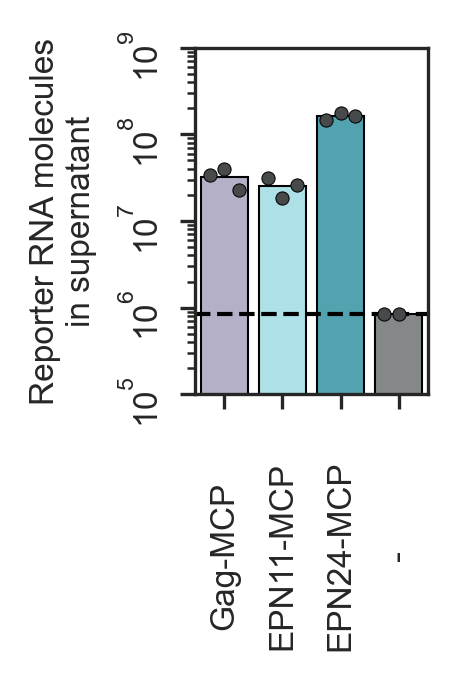

In [16]:
# Make simple bar plot, horizontal

field = "RNA molecules censored"

palette = ["#b1accc", "#a3e8f1", "#44adbf", "#83888a"]  # set color of bars

fig, ax = plt.subplots(1, 1, figsize=(1., 1.5))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e5, 1e9)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.barplot(ax=ax, x=x, y=y, palette=palette, lw=0.5, edgecolor="#010101")

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.25, 0, 0.25])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.array(list(np.tile(x_offset, int(len(x_swarm)/len(x_offset)))) + [-0.25, 0])

# Color by replicate well
ax.scatter(x_swarm_offset, y_swarm, color="#474a4b", edgecolor="#010101", linewidths=0.25, s=10, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_xlabel("")
ax.set_ylabel("Reporter RNA molecules\nin supernatant", labelpad=6)

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["Gag-MCP", "EPN11-MCP", "EPN24-MCP", "-"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center", va="center")

ax.tick_params(axis='x', which='major', pad=35)
ax.tick_params(axis='y', which='major', rotation=90)

ax.axhline(LOD, ls="--", color="k", lw=1)

save_figure(fig, "barplot_export_K562_GagMCP_EPN11MCP_EPN24MCP")

## Report enrichment

In [17]:
field = "RNA molecules censored"

x = summary.loc["41-1", field] / summary.loc["41-5", field]
print("Gag-MCP:", x)
print()

x = summary.loc["41-2", field] / summary.loc["41-5", field]
print("EPN11-MCP:", x)
print()

x = summary.loc["41-3", field] / summary.loc["41-5", field]
print("EPN24-MCP:", x)
print()

Gag-MCP: 38.515305459363546

EPN11-MCP: 30.39055328774631

EPN24-MCP: 194.56972941425784



# Visualize RNA export by Jurkat

In [18]:
# Choose samples
index_ordered = ["41-7", "41-8", "41-9", "41-11"]

In [19]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(4, 5)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored
Sample,,,,,
41-7,190.983280,76.234122,1.173246e+07,4.683204e+06,1.173246e+07
41-8,20.838672,1.577895,1.280158e+06,9.693302e+04,1.280158e+06
41-9,17.158003,8.761131,1.054048e+06,5.382126e+05,1.134737e+06
41-11,2.403720,0.503951,1.476650e+05,3.095867e+04,8.348521e+05


In [20]:
# Get data of replicates of selected wells

selector = cq_raw.index.isin(summary_subset.index)
data = cq_raw.loc[selector]

data = data.reset_index()

print(data.shape)
data.head()

(8, 17)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
0,41-8,D08,SYBR,mCherry,Unkn-20,NaN,28.175036,28.241011,0.093302,21.954412,1.341522,20.838672,1.577895,1.348700e+06,1.280158e+06,9.693302e+04,1.348700e+06
1,41-7,E07,SYBR,mCherry,Unkn-19,NaN,25.205992,25.563149,0.505097,244.888945,2.388969,190.983280,76.234122,1.504398e+07,1.173246e+07,4.683204e+06,1.504398e+07
2,41-8,E08,SYBR,mCherry,Unkn-20,NaN,28.306986,28.241011,0.093302,19.722931,1.294971,20.838672,1.577895,1.211616e+06,1.280158e+06,9.693302e+04,1.211616e+06
3,41-9,E09,SYBR,mCherry,Unkn-21,NaN,28.099008,28.564465,0.658255,23.353059,1.368344,17.158003,8.761131,1.434622e+06,1.054048e+06,5.382126e+05,1.434622e+06
4,41-11,E11,SYBR,mCherry,Unkn-23,NaN,30.727839,30.911692,0.260007,2.760068,0.440920,2.403720,0.503951,1.695561e+05,1.476650e+05,3.095867e+04,8.348521e+05


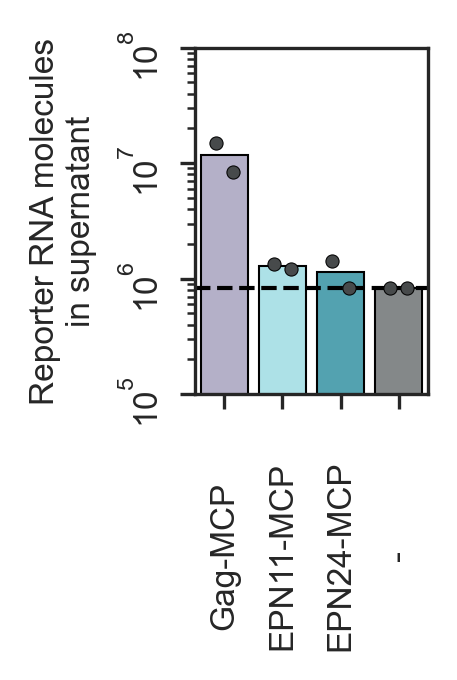

In [21]:
# Make simple bar plot, horizontal

field = "RNA molecules censored"

palette = ["#b1accc", "#a3e8f1", "#44adbf", "#83888a"]  # set color of bars

fig, ax = plt.subplots(1, 1, figsize=(1., 1.5))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e5, 1e8)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.barplot(ax=ax, x=x, y=y, palette=palette, lw=0.5, edgecolor="#010101")

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0.15])  # jitter offsets to avoid overlaps
x_swarm_offset = x_swarm + np.array(list(np.tile(x_offset, int(len(x_swarm)/len(x_offset)))))

# Color by replicate well
ax.scatter(x_swarm_offset, y_swarm, color="#474a4b", edgecolor="#010101", linewidths=0.25, s=10, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_xlabel("")
ax.set_ylabel("Reporter RNA molecules\nin supernatant", labelpad=6)

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["Gag-MCP", "EPN11-MCP", "EPN24-MCP", "-"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center", va="center")

ax.tick_params(axis='x', which='major', pad=35)
ax.tick_params(axis='y', which='major', rotation=90)

ax.axhline(LOD, ls="--", color="k", lw=1)

save_figure(fig, "barplot_export_Jurkat_GagMCP_EPN11MCP_EPN24MCP")

## Report enrichment

In [22]:
field = "RNA molecules censored"

x = summary.loc["41-7", field] / summary.loc["41-11", field]
print("Gag-MCP:", x)
print()

x = summary.loc["41-8", field] / summary.loc["41-11", field]
print("EPN11-MCP:", x)
print()

x = summary.loc["41-9", field] / summary.loc["41-11", field]
print("EPN24-MCP:", x)
print()

Gag-MCP: 14.053336516069772

EPN11-MCP: 1.5333952957204786

EPN24-MCP: 1.3592071330973772

